Neste Notebook, explorarei outras possibilidade para lidar com os dados desbalanceados. Treinaremos um modelo de redes neurais modificando os pesos para cada classe, como os dados já sofreram técnicas de resample, espera-se um melhor resultado na classe não majoritária.

In [ ]:
#Importando bibliotecas
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

# Carregando dados

In [ ]:
credit_st = pd.read_csv('credit_st.csv')  # Dados que passaram pelo processi de SMOTE e TOMEK LINKS
credit_st.drop(columns = [credit_st.columns[0], credit_st.columns[1]], inplace=True)  #Dropando a coluna de índices e detempo

credit_tl = pd.read_csv('credit_tl.csv') #Dados que passaram por TOMEK LINKS
credit_tl.drop(columns = [credit_tl.columns[0],credit_tl.columns[1]], inplace=True)

credit_test = pd.read_csv('credit_teste.csv') # Conjunto de teste
credit_test.drop(columns=[credit_test.columns[0],credit_test.columns[1]],inplace=True)

credit_st.dropna(inplace=True) #retirando os registros do tipo NAN

X_test, X_val, y_test, y_val = train_test_split(credit_test.iloc[:,:-1],credit_test.iloc[:,-1], test_size =0.2)  #Dividindo conjunto de teste em teste e validação para usar futuramente no treinamento do modelo

X_st, y_st = credit_st.iloc[:,:-1], credit_st.iloc[:,-1]  # Dividindo cada conjunto de dados em X e Y

X_tl, y_tl = credit_tl.iloc[:,:-1], credit_tl.iloc[:,-1]

In [ ]:
scaler_tl = StandardScaler() # Normalizando os dados para terem média 0 e desvio padrão 1
scaler_st = StandardScaler()

X_tl_train = scaler_tl.fit_transform(X_tl)
X_test_tl = scaler_tl.transform(X_test)
X_val_tl = scaler_tl.transform(X_val)


X_st_train = scaler_st.fit_transform(X_st)
X_test_st = scaler_st.transform(X_test)
X_val_st = scaler_st.transform(X_val)

print(f'Quantidade de registro em X_tl_train: {X_tl_train.shape[0]}')
print(f'Quantidade de registros em X_st_train: {X_st_train.shape[0]}')

Quantidade de registro em X_tl_train: 227828
Quantidade de registros em X_st_train: 229777


# Definindo parâmetros úteis para os modelos

In [ ]:
# Definindo métricas para o modelo

metricas = [
    keras.metrics.TruePositives(name='VV'),
    keras.metrics.TrueNegatives(name='VN'),
    keras.metrics.FalsePositives(name='FP'),
    keras.metrics.FalseNegatives(name='FN'),
    keras.metrics.BinaryAccuracy(name='acurácia'),
    keras.metrics.Precision(name='Precisão'),
    keras.metrics.Recall(name='Recall'),
    keras.metrics.AUC(name='AUC'),
    keras.metrics.AUC(name='PRC',curve='PR')
]

In [ ]:
# Definindo Modelo

def make_model(metrics = metricas, output_bias=None):
  if output_bias is not None:
    output_bias = keras.initializer.Constant(output_bias)

  model = keras.Sequential([
      keras.layers.Flatten(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid', bias_initializer = output_bias)
  ])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-3),
                loss = keras.losses.BinaryCrossentropy(),
                metrics=metrics)
  
  return model

In [ ]:
# Preparando uma parada antecipada

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_PRC',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights = True
)

# Definindo funções para analisar as métricas

In [ ]:
# Definindo função para plotar metricas

def plot_metrics(history):
  metrics = ['loss','PRC','Precisão','Recall']
  for n,metric in enumerate(metrics):
    name = metric.replace('_',' ').capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label = 'Train')
    plt.plot(history.epoch, history.history['val_'+metric], label='Val',linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


In [ ]:
# Plota matriz de confusão

def plot_matriz_conf(y, y_hat,p=0.5):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, y_hat>p)
    sns.heatmap(cm, annot=True)
    plt.ylabel('Rótulos verdadeiros')
    plt.xlabel('Rótulos previstos')
    plt.xticks([.5,1.5],['Não Houve fraude','houve fraude'], rotation=0)
    plt.yticks([0.5,1.5],['Não Houve fraude','houve fraude'],rotation=0)
    plt.title('Matriz de Confusão')

In [ ]:
# Função para plotar ROC

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth = 2, **kwargs)
  plt.xlabel('Falso Positivo [%]')
  plt.ylabel('Verdadeiro Positivo [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
# Função para plotar curva PR

def plot_prc(name, labels,predictions, **kwargs):
  precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

  plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
  plt.xlabel('Precisão')
  plt.ylabel('Recall')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

# Treinando modelo usando os dados que passaram por Smote

In [ ]:
# Treinando modelo com os dados que passaram por SMOTE e TomekLinks
model_st = make_model()
EPOCHS = 100

history_st = model_st.fit(
    X_st_train,
    y_st,
    epochs = EPOCHS,
    callbacks = [early_stopping],
    validation_data = (X_val_st,y_val),
)

Epoch 1/100
7181/7181 [==============================] - 53s 7ms/step - loss: 0.0484 - VV: 1836.0000 - VN: 224659.0000 - FP: 2574.0000 - FN: 708.0000 - acurácia: 0.9857 - Precisão: 0.4163 - Recall: 0.7217 - AUC: 0.9527 - PRC: 0.7198 - val_loss: 0.0050 - val_VV: 10.0000 - val_VN: 11372.0000 - val_FP: 7.0000 - val_FN: 4.0000 - val_acurácia: 0.9990 - val_Precisão: 0.5882 - val_Recall: 0.7143 - val_AUC: 0.8918 - val_PRC: 0.5074
Epoch 2/100
7181/7181 [==============================] - 38s 5ms/step - loss: 0.0109 - VV: 2113.0000 - VN: 227151.0000 - FP: 82.0000 - FN: 431.0000 - acurácia: 0.9978 - Precisão: 0.9626 - Recall: 0.8306 - AUC: 0.9791 - PRC: 0.9130 - val_loss: 0.0053 - val_VV: 10.0000 - val_VN: 11373.0000 - val_FP: 6.0000 - val_FN: 4.0000 - val_acurácia: 0.9991 - val_Precisão: 0.6250 - val_Recall: 0.7143 - val_AUC: 0.8916 - val_PRC: 0.4332
Epoch 3/100
7181/7181 [==============================] - 38s 5ms/step - loss: 0.0101 - VV: 2103.0000 - VN: 227152.0000 - FP: 81.0000 - FN: 441.000

# Modificando Pesos Para cada classe

In [ ]:
# Calculando quantidade de rótulos negativos e positivos
credit_df = pd.read_csv('creditcard.csv')
neg, pos = np.bincount(credit_df['Class'])
total = neg+pos


In [ ]:
# Modificando peso do modelo para dar mais atenção ao caso fraudulento 

peso_0 = (1/neg)*(total/2)
peso_1 = (1/pos)*(total/2)

class_weight = {0:peso_0, 1:peso_1}

print(f'O peso da classe 0 será {peso_0}')
print(f'O peso da classe 1 será {peso_1}')


O peso da classe 0 será 0.5008652375006595
O peso da classe 1 será 289.43800813008136


Ao modificar o peso das classe, é necessário tomar cuidado com o otimizador escolhido, o uso do Adam evita problemas devido a escalabilidade

In [ ]:
# Treinando para os dados que sofreram Tomek Links
weighted_model_tl = make_model()
EPOCHS = 100

history_tl = weighted_model_tl.fit(
    X_tl_train,
    y_tl,
    epochs = EPOCHS,
    callbacks = [early_stopping],
    validation_data = (X_val_tl,y_val),
    class_weight = class_weight
)

Epoch 1/100
7120/7120 [==============================] - 41s 5ms/step - loss: 0.3065 - VV: 335.0000 - VN: 221028.0000 - FP: 17784.0000 - FN: 74.0000 - acurácia: 0.9253 - Precisão: 0.0185 - Recall: 0.8191 - AUC: 0.9291 - PRC: 0.4893 - val_loss: 0.1436 - val_VV: 12.0000 - val_VN: 11192.0000 - val_FP: 187.0000 - val_FN: 2.0000 - val_acurácia: 0.9834 - val_Precisão: 0.0603 - val_Recall: 0.8571 - val_AUC: 0.9629 - val_PRC: 0.4697
Epoch 2/100
7120/7120 [==============================] - 38s 5ms/step - loss: 0.2022 - VV: 344.0000 - VN: 221239.0000 - FP: 6194.0000 - FN: 51.0000 - acurácia: 0.9726 - Precisão: 0.0526 - Recall: 0.8709 - AUC: 0.9700 - PRC: 0.6336 - val_loss: 0.0895 - val_VV: 11.0000 - val_VN: 11253.0000 - val_FP: 126.0000 - val_FN: 3.0000 - val_acurácia: 0.9887 - val_Precisão: 0.0803 - val_Recall: 0.7857 - val_AUC: 0.9601 - val_PRC: 0.4916
Epoch 3/100
7120/7120 [==============================] - 38s 5ms/step - loss: 0.2043 - VV: 349.0000 - VN: 221897.0000 - FP: 5536.0000 - FN: 46.

# Analisando métricas para o 1° modelo

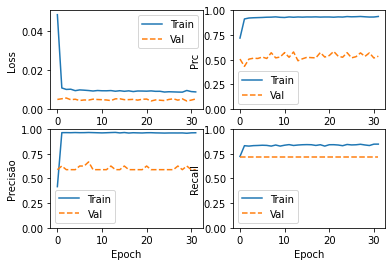

In [ ]:
#Plotando o valor das métricas por época
plot_metrics(history_st)

Como podemos ver a loss diminui com o passar das épocas, comportamento normal já que queremos minimizar a loss. O importante a notar nesse gráfico é que a precisão do conjunto de dados de treino está muito próxima do 100%, enquanto no conjunto de validação está muito baixa, isso indica que, apesar do uso de camadas de dropout, o modelo sofreu com overfitting. Desse modo, seria adequado usar mais técnicas de regularização para melhorar o modelo.

1425/1425 [==============================] - 6s 4ms/step - loss: 0.0038 - VV: 65.0000 - VN: 45464.0000 - FP: 22.0000 - FN: 18.0000 - acurácia: 0.9991 - Precisão: 0.7471 - Recall: 0.7831 - AUC: 0.9449 - PRC: 0.7496
loss : 0.003793372306972742
VV : 65.0
VN : 45464.0
FP : 22.0
FN : 18.0
acurácia : 0.9991222023963928
Precisão : 0.7471264600753784
Recall : 0.7831325531005859
AUC : 0.9448534250259399
PRC : 0.7496428489685059
[[3.7294517e-06]
 [1.0147605e-04]
 [7.0481398e-09]
 ...
 [8.8058096e-06]
 [3.9233956e-07]
 [2.9169942e-07]]


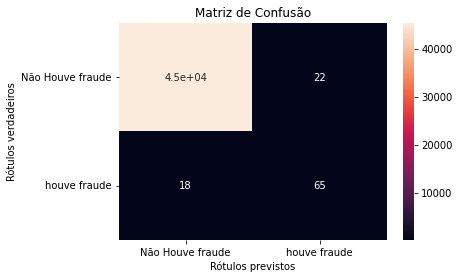

In [ ]:
#Fazendo previsões
train_predictions_model = model_st.predict(X_st_train)
test_predictions_model = model_st.predict(X_test_st)

model_st_result = model_st.evaluate(X_test_st, y_test)

#Escrevendo valores úteis
for name, value in zip(model_st.metrics_names, model_st_result):
  print(f'{name} : {value}')

#Plotando matriz de confusão
print(test_predictions_model)
plot_matriz_conf(y_test, test_predictions_model) 

Pela matriz de confusão acima, a acurácia ficou alta, aproximadamente 99.91%, comportamento normal em conjunto de dados desbalanceados, portanto não deve ser considerado como uma boa métrica para medir o desempenho do modelo. A precisão e o recall estão quase empatados,  74.71% e 78.31%, respectivamente. Tentaremos melhorar o recall, em troca disso espera-se uma queda na precisão.

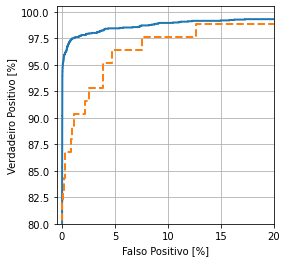

In [ ]:
#Plotando curva roc
plot_roc('Conjunto de treino', y_st, train_predictions_model)
plot_roc('Conjunto de teste', y_test, test_predictions_model, linestyle = '--')

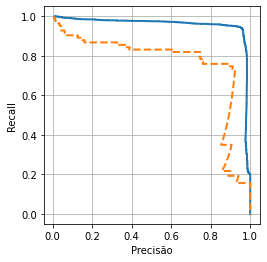

In [ ]:
#Plotando curva prc
plot_prc('Conjunto de treino', y_st, train_predictions_model)
plot_prc('Conjunto de teste', y_test, test_predictions_model, linestyle = '--')

Como mencionado anteriormente, quando a precisão, cresce o recall diminui. Quando a precisão diminui, o recall aumenta

# Analisando métricas para o modelo 2

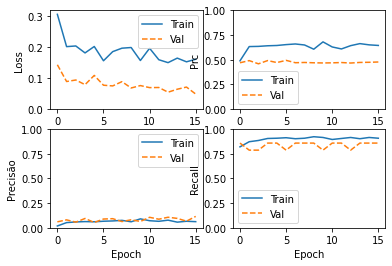

In [ ]:
#Plotando o valor das métricas por época
plot_metrics(history_tl) 

A loss está muito alta se comparada ao modelo anterior. O fato mais notório é a queda da precisão em ambos os conjuntos de dados, como modificamos os pesos do modelo, era esperado uma precisão baixa em troca do aumento do recall.

1425/1425 [==============================] - 6s 4ms/step - loss: 0.0743 - VV: 73.0000 - VN: 44977.0000 - FP: 509.0000 - FN: 10.0000 - acurácia: 0.9886 - Precisão: 0.1254 - Recall: 0.8795 - AUC: 0.9893 - PRC: 0.7018
loss : 0.07426592707633972
VV : 73.0
VN : 44977.0
FP : 509.0
FN : 10.0
acurácia : 0.9886106848716736
Precisão : 0.12542955577373505
Recall : 0.8795180916786194
AUC : 0.9893007874488831
PRC : 0.7017682194709778



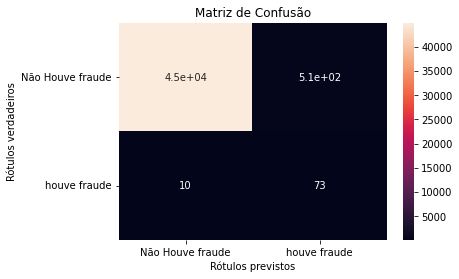

In [ ]:
#Fazendo previsões
train_predictions_model = weighted_model_tl.predict(X_tl_train)
test_predictions_model = weighted_model_tl.predict(X_test_tl)

model_tl_result = weighted_model_tl.evaluate(X_test_tl, y_test)

#Escrevendo valores úteis
for name, value in zip(weighted_model_tl.metrics_names, model_tl_result):
  print(f'{name} : {value}')

#Plotando matriz de confusão
print()
plot_matriz_conf(y_test, test_predictions_model) 

Aqui tivemos um salto no recall em comparação com o modelo anterior de 78.31% para 87.95%, uma melhora considerável. Em troca dessa melhora a precisão despencou para 12.54%, mas não nós preucuparemos com isso, pois outras técnicas podem ser aplicadas para detectar outliers em quem foi detectado como classe 1, assim podemos separar quem realmente é fraude e quem não é.

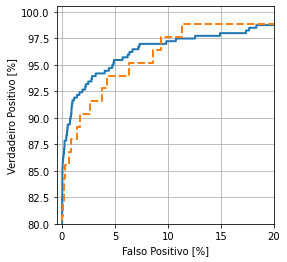

In [ ]:
#Plotando curva roc
plot_roc('Conjunto de treino', y_tl, train_predictions_model)
plot_roc('Conjunto de teste', y_test, test_predictions_model, linestyle = '--')

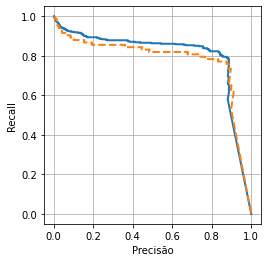

In [ ]:
#Plotando curva prc
plot_prc('Conjunto de treino', y_tl, train_predictions_model)
plot_prc('Conjunto de teste', y_test, test_predictions_model, linestyle = '--')

No próximo notebook, tentarei obter um recall ainda melhor, para isso abandonarei completamente a preucupação com a precisão. Essa etapa será apenas por diversão, esse modelo anterior poderia ser usado junto com detecção de outliers para formar um modelo muito bom.